In [1]:
 !pip install neat-python

     |████████████████████████████████| 51kB 2.8MB/s 


In [2]:
# Load the config file from G-Drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

try:
    a
except NameError:
    a = None


if a == None: 
  %cd /gdrive
  %cd My Drive
  %cd NEAT/ 
  %ls

a = 1
# config_file = '/content/drive/My Drive/NEAT/xor_config'
config_file = 'xor_config'



Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/NEAT
config-feedforward.txt  neat-checkpoint-229  neat-checkpoint-433
config_lunar            neat-checkpoint-232  neat-checkpoint-449
config_lunar_partial    neat-checkpoint-239  neat-checkpoint-464
neat2_29in10out.cfg     neat-checkpoint-247  neat-checkpoint-47
neat2.cfg               neat-checkpoint-249  neat-checkpoint-48
neat_42.cfg             neat-checkpoint-250  neat-checkpoint-484
neat.cfg                neat-checkpoint-259  neat-checkpoint-49
neat.cfg.gdoc           neat-checkpoint-26   neat-checkpoint-50
neat-checkpoint-105     neat-checkpoint-269  neat-checkpoint-500
neat-checkpoint-106     neat-checkpoint-27   neat-checkpoint-514
neat-checkpoint-108     neat-checkpoint-270  neat-checkpoint-529
neat-checkpoint-109     neat-checkpoint-279  neat-checkpoint-543
neat-checkpoint-110     neat-checkpoint-289  neat-checkpoint-555
neat-checkpoint-119     neat-checkpoint-29   neat-checkpoint-567
neat-checkpoint-120     neat

In [3]:
import neat
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# from bayesian_optimization_util import plot_approximation, plot_acquisition

%matplotlib inline

In [4]:
import numpy as np

import matplotlib.pyplot as plt

def plot_approximation(gpr, X, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    # plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')


.



# **Bayesian Optimisation**



 **Expected Improvement** 





In [5]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):

    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):

    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [6]:
# bounds = np.array([[-1.0, 2.0]])
# noise = 0.2

# def f(X, noise=noise):
#   #  return (X**2 * np.sin(2 * np.pi * X)**6.0) + noise
#    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

# X_init = np.array([[-0.9], [1.1]])
# Y_init = f(X_init)


# # Dense grid of points within bounds
# X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# # Noise-free objective function values at X 
# Y = f(X,0)
# plt.plot(X, Y,  lw=2, label='Objective function')

# plt.legend();

In [7]:
# NEAT BlackBox Function to be optimised:

# NEAT XOR

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,),     (1.0,),     (1.0,),     (0.0,)]

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        # print('A'*150)
        # print(genome)
        # print(type(genome))
        # print('A' * 150)
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2



def f(a, noise=None):
  ret_list = list()
  for i in range(20):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)


    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    # print('=========================================')
    # print(str(p))
    # print('=========================================')

    p.config.genome_config.enabled_mutate_rate = a # works, optimal at zero 0.0
    # p.config.genome_config.node_add_prob = a
    # p.config.genome_config.node_delete_prob = a
    # p.config.genome_config.aggregation_mutate_rate = a

    # Add a stdout reporter to show progress in the terminal.
    # p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    # p.add_reporter(neat.Checkpointer(5))

    # Run for up to 500 generations.
    winner = p.run(eval_genomes, 500)
    ret_list.append(-len(stats.generation_statistics))

  return np.mean(ret_list)/500


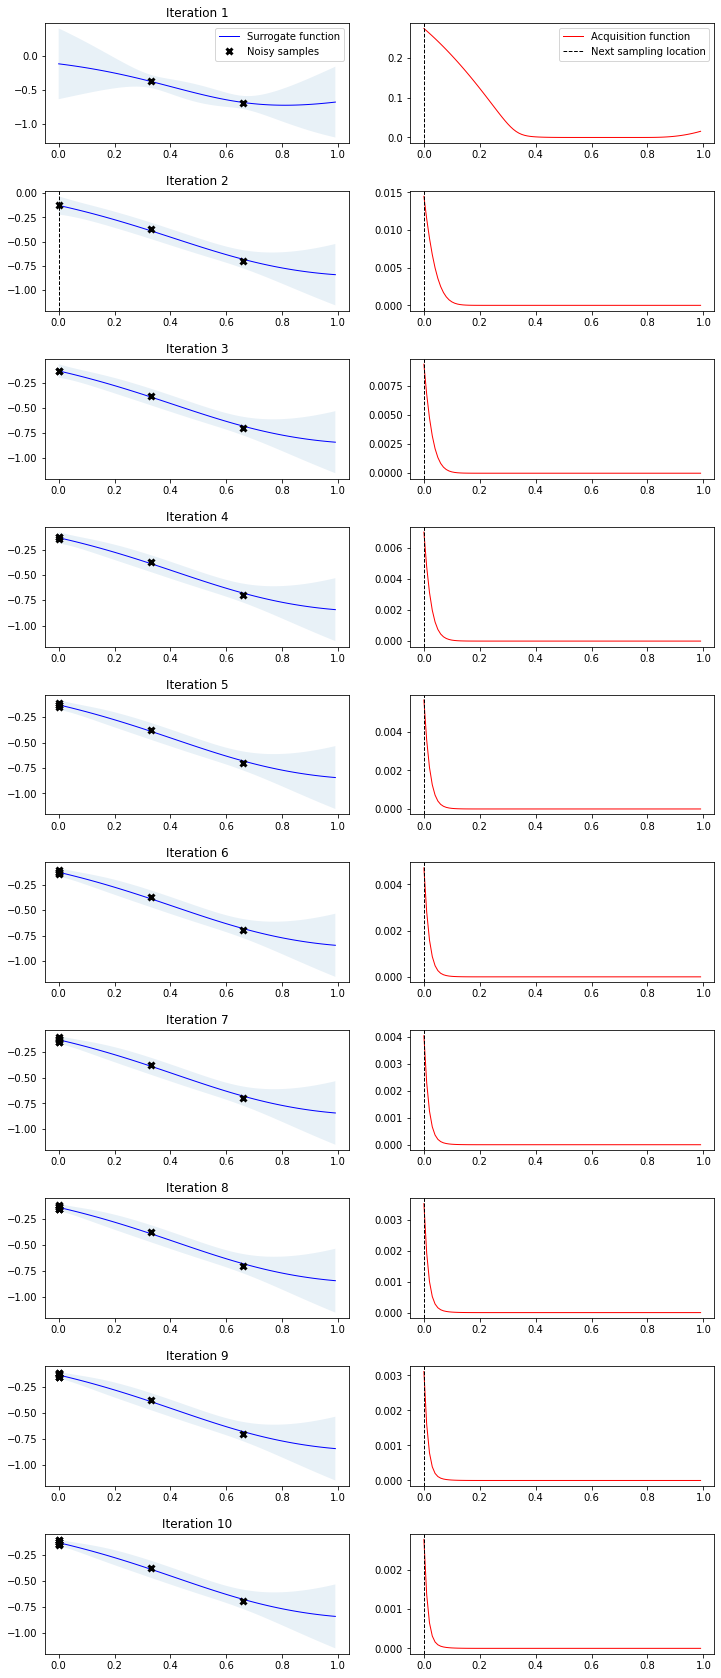

In [8]:
noise=0.05


x1 = 0.33
x2 = 0.66

y1 = f(x1)
y2 = f(x2)

X_init = np.array([[x1], [x2]])
Y_init = np.array([[y1], [y2]])

bounds = np.array([[0, 1.0]])


# # Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) #rbf generalisation
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [9]:
X_sample

array([[3.30000000e-01],
       [6.60000000e-01],
       [0.00000000e+00],
       [1.38777878e-17],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

In [10]:
Y_sample*500

array([[-186.55],
       [-349.25],
       [ -63.45],
       [ -62.4 ],
       [ -75.1 ],
       [ -54.55],
       [ -65.6 ],
       [ -74.9 ],
       [ -77.05],
       [ -55.1 ],
       [ -71.7 ],
       [ -62.25]])

In [11]:
# Now random search:
num_evals = 12
scores = list()
params_list = list()
for i in range(num_evals):
  param = np.random.uniform(low=0.0, high=1.0, size=1)
  params_list.append(param)

  scores.append(f(param[0]))

In [12]:
[i*500 for i in scores]

[-342.45,
 -362.15,
 -357.8,
 -69.85,
 -122.0,
 -219.2,
 -398.05,
 -114.3,
 -452.4,
 -124.55,
 -283.7,
 -279.45]

In [13]:
params_list

[array([0.58356892]),
 array([0.53786869]),
 array([0.72110239]),
 array([0.03623946]),
 array([0.24245414]),
 array([0.40838984]),
 array([0.70063901]),
 array([0.22005146]),
 array([0.90565126]),
 array([0.19805822]),
 array([0.56650986]),
 array([0.48388872])]